In [1]:
%matplotlib inline
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K
import matplotlib.pyplot as plt
import os
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from operator import itemgetter
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] ='false'
os.environ['XLA_PYTHON_CLIENT_ALLOCATOR']='platform'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
print(tf.config.list_physical_devices('GPU'))

2023-08-31 11:25:32.389296: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-31 11:25:32.847707: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-31 11:25:34.959851: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/software/spackages/linux-rocky8-x86_64/gcc-9.5.0/anaconda3-2022.05-zyrazrj6uvrtukupqzhaslr63w7hj6in/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected 

[]


2023-08-31 11:25:39.724741: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-08-31 11:25:39.724792: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: node0387.palmetto.clemson.edu
2023-08-31 11:25:39.724796: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: node0387.palmetto.clemson.edu
2023-08-31 11:25:39.724857: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 525.125.6
2023-08-31 11:25:39.724868: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 525.125.6
2023-08-31 11:25:39.724870: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 525.125.6


In [ ]:

model_path = "models/MNIST_model"
m = tf.saved_model.load(model_path)  ##CNN model
model_path_2 = "models/VAE_model"
vae = tf.saved_model.load(model_path_2)  #VAE
model_path_3 = "models/encoder_model"
encoder = tf.saved_model.load(model_path_3)
model_path_4 = "models/decoder_model"
decoder = tf.saved_model.load(model_path_4)

OSError: SavedModel file does not exist at: VAE.pb/{saved_model.pbtxt|saved_model.pb}

In [29]:
combined_model = keras.Model(inputs=vae.input,
                                 outputs=m.output,name="combined")

AttributeError: '_UserObject' object has no attribute 'input'

In [3]:
from operator import itemgetter
from itertools import groupby
import scipy.stats as st
from matplotlib.patches import Polygon
(x_train, y_train), (x_test,y_test) = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255
x_test = np.expand_dims(x_test, -1).astype("float32") / 255

_,_,z = encoder(x_test)   #Test images are 10,000 -> each image should have a corresponding
l = zip(z,y_test)
sort_list = sorted(l,key = itemgetter(1))
print(sort_list[1])
sorted_list = []
sorting_list = []
integer_95 = ()
for i in range(10):
    sorted_list = [values for values,key in sort_list if key == i]
    x = [item [0] for item in sorted_list]
    y = [item [1] for item in sorted_list]
    z = [item [2] for item in sorted_list]
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    mean_z = np.mean(z)
    std_error_x = st.sem(x)
    std_error_y = st.sem(y)
    std_error_z = st.sem(z)
    x_95 = st.t.interval(alpha=0.95, df=len(x)-1, loc= mean_x, scale = std_error_x)
    y_95 = st.t.interval(alpha=0.95, df=len(y)-1, loc= mean_y, scale = std_error_y)
    z_95 = st.t.interval(alpha=0.95, df=len(z)-1, loc= mean_z, scale = std_error_z)
    #print([x_95, y_95, z_95])  #These are the bounds 95% confidence bounds of the "n" classes with "m" latent dimensions -> size = ((n x 2) x m). 
                       # They are bounds for the sample space "z" which will be the input to the decoder and subsequently the CNN

(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-3.606621 ,  1.6182556,  2.5616846], dtype=float32)>, 0)


In [4]:
def plot_3D_clusters(encoder, data, labels):
    # display a 3D plot of the digit classes in the latent space
    _, _, z_mean = encoder(data)
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(projection="3d")
    p = plt.scatter(z_mean[:, 0], z_mean[:, 1], z_mean[:,2], c=labels)
    fig.colorbar(p)
    ax.set_xlabel("z[0]")
    ax.set_ylabel("z[1]")
    ax.set_zlabel("z[2]")
    plt.show()

In [25]:
def plot_label_clusters(z, labels):
    # display a 2D plot of the digit classes in the latent space
    l = zip(z,labels)
    sort_list = sorted(l,key = itemgetter(1))
    figs = {}
    axs = {}
    for i in range(10):
        sorted_list = [values for values,key in sort_list if key == i]
        x = [item [0] for item in sorted_list]
        y = [item [1] for item in sorted_list]
        z = [item [2] for item in sorted_list]
        # mean_x = np.mean(x)
        # mean_y = np.mean(y)
        # mean_z = np.mean(z)
        # std_error_x = st.sem(x)
        # std_error_y = st.sem(y)
        # std_error_z = st.sem(z)
        # x_95 = st.t.interval(alpha=0.95, loc= mean_x, scale = std_error_x)
        # y_95 = st.t.interval(alpha=0.95, loc= mean_y, scale = std_error_y)
        # z_95 = st.t.interval(alpha=0.95, loc= mean_z, scale = std_error_z)
        
        ## Create convex hull and vertices
        hull = ConvexHull(list(zip(x,y,z)))
        vertex = hull.vertices
        poly_coord = []
        for ii in vertex:
            ## Create polygon coordinates
            poly_coord += [(x[ii],y[ii],z[ii])]
        
        ## Plot samples and convex hull
        figs[i] = plt.figure(figsize=(12, 10))
        plt.scatter(x, y, z) 
        axs[i] = figs[i].add_subplot(projection="3d")
        axs[i].add_patch(Polygon(poly_coord, color='forestgreen', alpha=0.1))
        axs[i].set_xlabel("z[0]")
        axs[i].set_ylabel("z[1]")
        axs[i].set_zlabel("z[2]")
        plt.title("This is latent space for Digit " + str(i) )
        plt.show()

In [31]:
def plot_label_clusters_2D(z, labels):
    # display a 2D plot of the digit classes in the latent space
    
    l = zip(z,labels)
    sort_list = sorted(l,key = itemgetter(1))
    figs = {}
    axs = {}
    
    for i in range(10):
        sorted_list = [values for values,key in sort_list if key == i]
        x = [item [0] for item in sorted_list]
        y = [item [1] for item in sorted_list]
        mean_x = np.mean(x)
        mean_y = np.mean(y)
        print(mean_x)
        print(mean_y)
        # std_error_x = st.sem(x)
        # std_error_y = st.sem(y)
        # x_95 = st.t.interval(alpha=0.99, df=len(x)-1, loc= mean_x, scale = std_error_x)
        # y_95 = st.t.interval(alpha=0.99, df=len(y)-1, loc= mean_y, scale = std_error_y)

        
        ## Create convex hull and vertices
        hull = ConvexHull(list(zip(x,y)))
        vertex = hull.vertices
        poly_coord = []
        for ii in vertex:
            ## Create polygon coordinates
            poly_coord += [(x[ii],y[ii])]
        
        ## Plot samples and convex hull
        figs[i] = plt.figure(figsize=(12, 10))
        axs[i] = figs[i].add_subplot()
        axs[i].add_patch(Polygon(poly_coord, color='forestgreen', alpha=0.5))
        plt.scatter(x,y) 
        plt.xlabel("z[0]")
        plt.ylabel("z[1]")
        plt.title("This is latent space for Digit " + str(i) )
        plt.show()
        

-4.715783
1.4955636


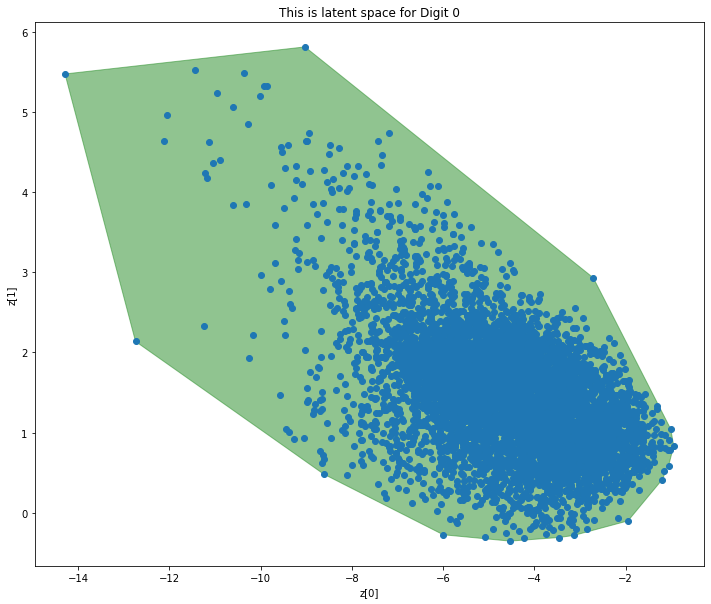

-23.247362
12.201122


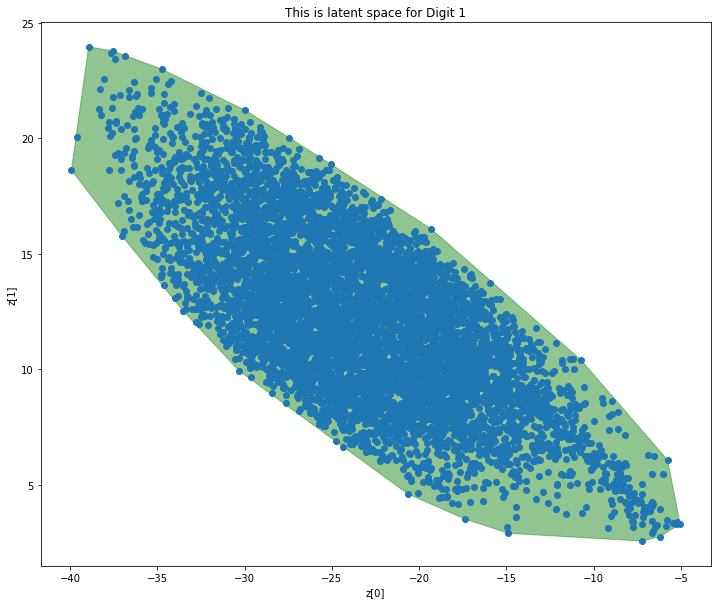

-6.1884255
3.108108


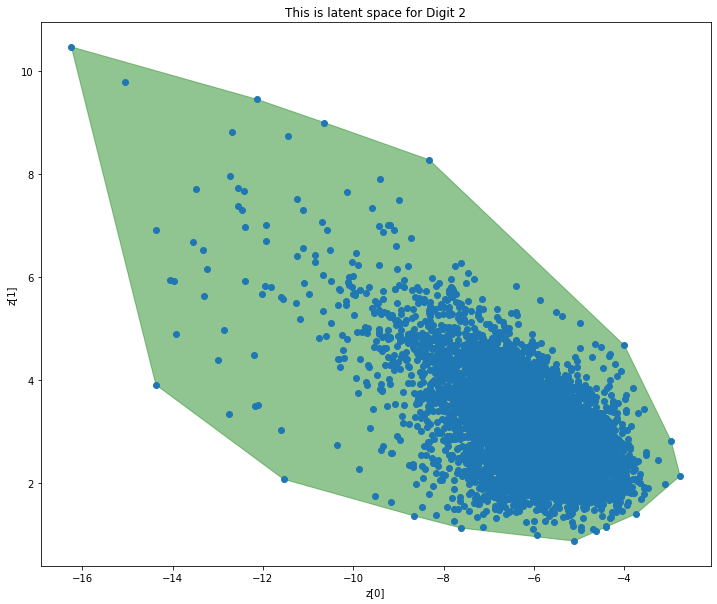

-6.4512625
3.6987271


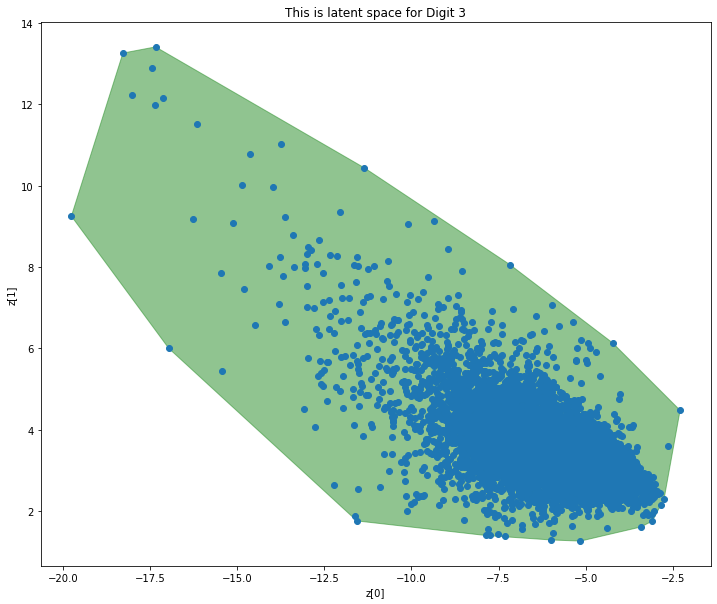

-7.0561333
4.667146


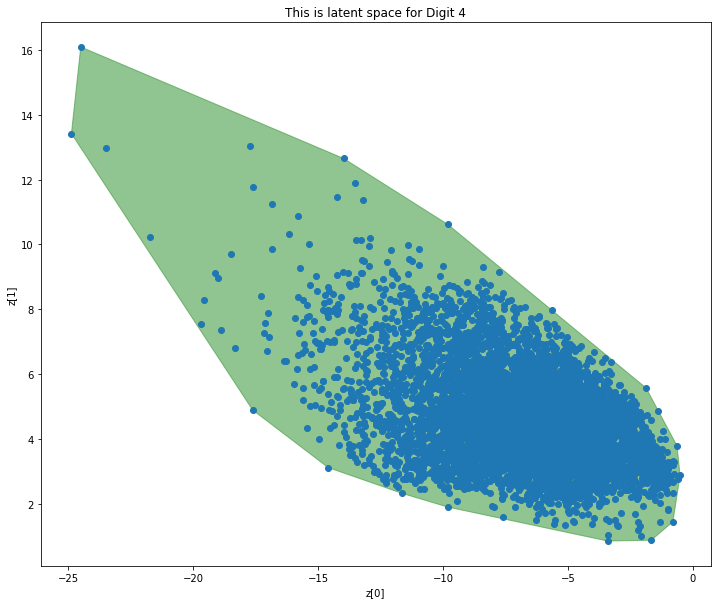

-7.278415
2.949578


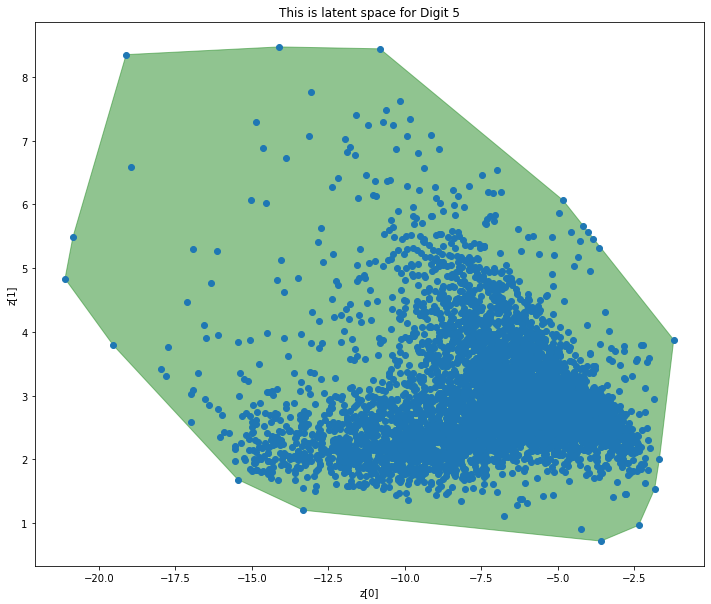

-6.3269653
3.0130165


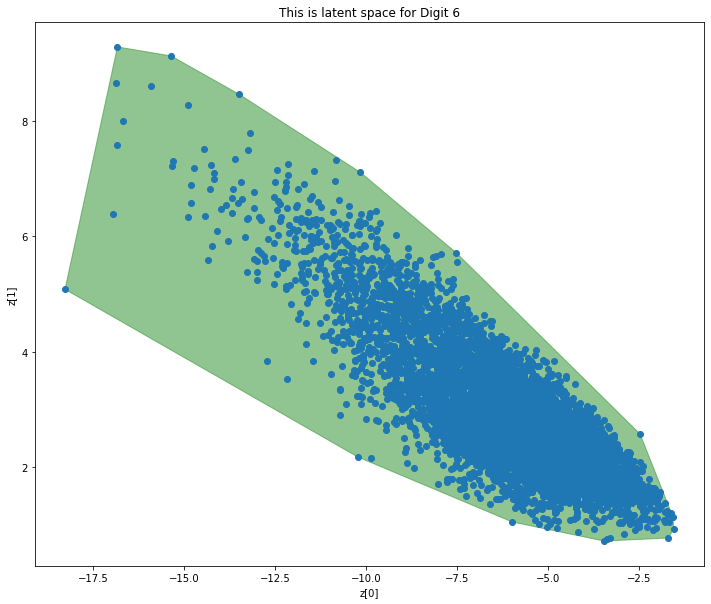

-10.472503
6.4386697


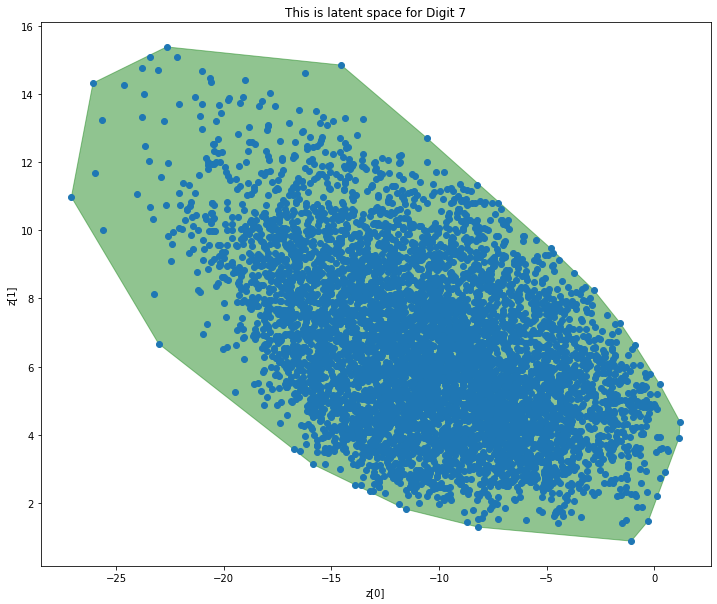

-7.9259715
3.817909


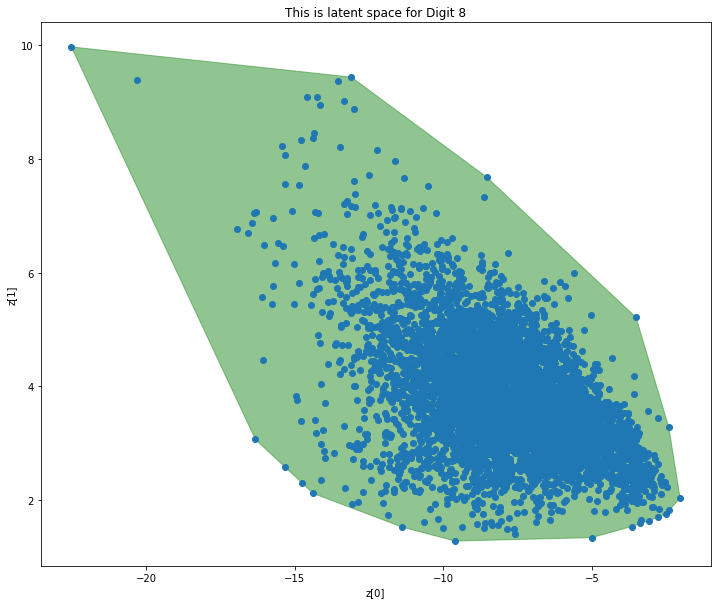

-8.345041
5.7077856


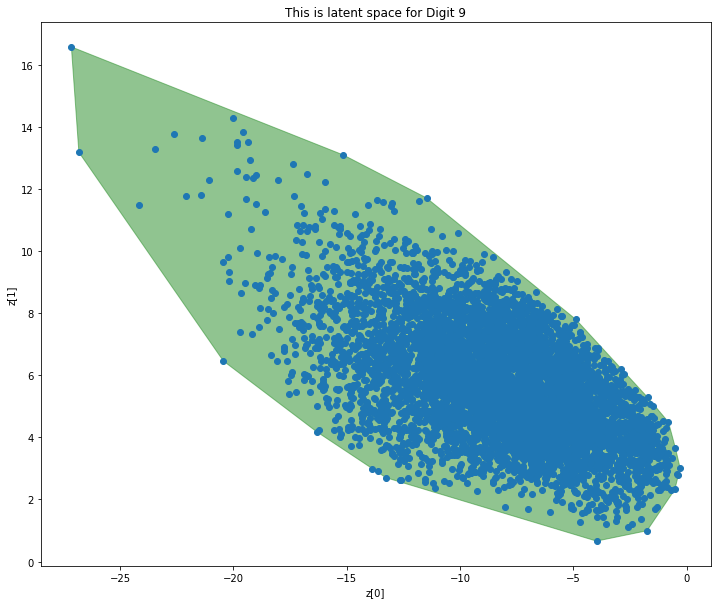

In [32]:
latent_dim = 3
_,_,z = encoder(x_train)

plot_label_clusters_2D(z, y_train)
#plot_3D_clusters(encoder, x_train, y_train)
#plot_label_clusters(z, y_train)
#x_decoded = vae(x_test)

In [ ]:
# load the saved_model using low-level API
index = 36
plt.figure(1)
plt.imshow(x_decoded[index])
plt.title("This is the recreated image")

plt.figure(2)
plt.imshow(x_test[index])
plt.title("This is the original image")
print("This is the real label:" + str(y_test[index]))

prediction_from_decoder = m(x_decoded)
print("This is the predicted label of the recreated image:" + str(y_test[np.argmax(prediction_from_decoder[index])]))

prediction_input_image = m(x_test)
print("This is the predicted label of the original image:" + str(y_test[np.argmax(prediction_input_image[index])]))


#tfm = tf.function(lambda x: m(x))  # full model   
#tfm.summary()